# Initialize NMRlipids databank

In [2]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import MDAnalysis
import urllib.request
import yaml

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

path = '../../Databank/Data/Simulations/'
db_data = databank(path)
systems = db_data.get_systems()

mkdir: cannot create directory ‘./results/POPS_in_POPC/’: File exists
/bin/sh: 1: Syntax error: "(" unexpected
/bin/sh: 1: Syntax error: "(" unexpected
sort: cannot read: ./results/POPS_in_POPC/T320.0K_CHARMM36: No such file or directory
/bin/sh: 1: Syntax error: "(" unexpected


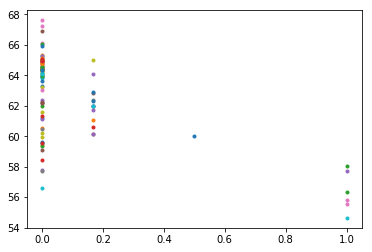

In [64]:
MATRIX = 'POPC'
ADDITIVE = 'POPS'

ResultDir = './results/' + ADDITIVE + '_in_' + MATRIX + '/'
!mkdir {ResultDir}
!rm {ResultDir}/*

apl_DICT = {}
for system in systems:
    
    try:
        NADDITIVE = np.sum(system['COMPOSITION'][ADDITIVE]['COUNT'])
    except:
        NADDITIVE = 0    
    
    try:
        NMATRIX = np.sum(system['COMPOSITION'][MATRIX]['COUNT'])
    except:
        NMATRIX = 0
    
    NLIPIDS = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            NLIPIDS += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    if (NMATRIX + NADDITIVE) != NLIPIDS:
        #print('skipped')
        continue
    
    
    APLpath = system['path'] + 'apl.json'
    try:
        f = open(APLpath)
        APLdata = json.load(f)
    except:
        print('apl.json not found from' + system['path'])
        
    sumAPL = 0
    sumIND = 0
    for i,j in APLdata.items():
        sumAPL += j
        sumIND += 1
    APL = sumAPL/sumIND
    
    plt.plot(NADDITIVE / NLIPIDS, APL,'.')
    
    try:
        CaConcentration = system['COMPOSITION']['CAL']['COUNT'] * 55.5 / system['COMPOSITION']['SOL']['COUNT']
    except:
        CaConcentration = 0
    lipidsRATIO = 100*NADDITIVE / NLIPIDS
    forcefield = system.get('FF')
    temperature = system.get('TEMPERATURE')
    DOI = system.get('DOI')
    apl_DICT[lipidsRATIO,CaConcentration,forcefield,temperature,DOI] = APL
   
    OutFileName = ResultDir + 'T' + str(temperature) + 'K'

    try:
        NSOD = np.sum(system['COMPOSITION']['SOD']['COUNT'])
    except:
        NSOD = 0    
        
    try:
        NCLA = np.sum(system['COMPOSITION']['CLA']['COUNT'])
    except:
        NCLA = 0    
    
    if NCLA > 0 and not 'DHMDMAB' in ADDITIVE:
        #print('skipped')
        continue
        
    if ('POPG' in ADDITIVE or 'POPS' in ADDITIVE) and NADDITIVE != NSOD:
        #print('skipped')
        continue
    
    try:
        OutFileName = OutFileName + '_' + system['FF'] +'.dat'
    except:
        continue
    #print(OutFileName)
    
    outfile=open(OutFileName,'a')
    outfile.write(str(round(lipidsRATIO,3)) + " " + str(APL) + " " + str(system['DOI']))
    outfile.write('\n')
    outfile.close()
    !sort -n -k 1 {OutFileName} -o {OutFileName}

Text(0,0.5,'Area per molecule (nm)^2')

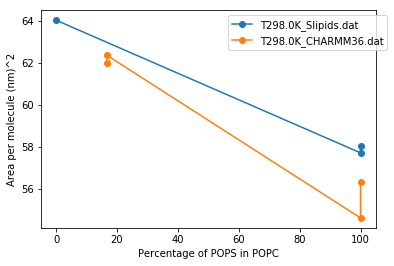

In [65]:
for subdir, dirs, files in os.walk(ResultDir):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".dat"):
            with open(filepath) as APLfile:
                lines = APLfile.readlines()#[1:]
                x = [float(line.split()[0]) for line in lines]
                y = [float(line.split()[1]) for line in lines]
                #print(filepath,x,y)
                if len(set(x)) > 1:
                    plt.plot(x,y,label = filename,marker='o')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.xlabel('Percentage of ' + ADDITIVE + ' in ' + MATRIX)
plt.ylabel('Area per molecule (nm)^2')
#plt.savefig('../Figs/aplTST.png', bbox_inches='tight')